In [10]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict
from itertools import product
from dataclasses import dataclass
import os
import math
import sys
from typing import Dict, Any, List, Optional
sys.path.append('../../../../')

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
import pandas as pd

from matplotlib.ticker import FuncFormatter

from multitask_nlp.utils.plotting import Task, get_overall_score, visualize_boxplot, plot_gain_matrix

color_pallette = 'muted'
sns.set_theme(style='whitegrid', context='talk', palette=color_pallette, 
              rc={'font.family': 'serif', 'font.serif': 'Times New Roman', 'mathtext.fontset': 'dejavuserif'})

tasks = [
    Task(name='Aspectemo', measure='micro_f1_sentiment', 
         measure_name='Micro F1', size=1303),
    Task(name='Multiemo', measure='macro_f1_sentiment', 
         measure_name='Macro F1', size=6572),
    Task(name='AllegroReviews', measure='w_mae_score_rating', 
         measure_name=r'$1-wMAE$', size=8180),
    Task(name='CBD', measure='macro_f1_target', 
         measure_name='Macro F1', size=8041),
    Task(name='CDSC-E', measure='macro_f1_entailment_judgment', 
         measure_name='Macro F1', size=7000),
    Task(name='CDSC-R', measure='r2_relatedness_score', 
         measure_name='R2', size=7000),
    Task(name='DYK', measure='macro_f1_target', 
         measure_name='Macro F1', size=4103),
    Task(name='NKJP_NER', measure='macro_f1_target', 
         measure_name='Macro F1', size=13794),
    Task(name='PSC', measure='macro_f1_label', 
         measure_name='Macro F1', size=3302)
]

cols_to_display = ['dataset', 'learning_kind', 'model_name', 'model_type',
       'mt_dataset_type',  'scale_class_loss', 'uncertainty_loss', 'type', 'overall_score', 'weighted_overall_score']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
for task in tasks:
    print(task.name, end='')
    if task.short_name is not None:
        print(f' ({task.short_name}), ', end='')
    else:
        print(', ', end='')

Aspectemo, Multiemo, AllegroReviews, CBD, CDSC-E, CDSC-R, DYK, NKJP_NER, PSC, 

In [4]:
def get_type(row):
    ttype = row['learning_kind']
    if not pd.isna(row['mt_dataset_type']):
        ttype += '_' + str(row['mt_dataset_type'])
        if row['mt_dataset_type'] == 'proportional_sampling':
            ttype += r'_$\alpha={}$'.format(row['alpha'])
        
    return ttype


def load_results_df(file_path: str):
    df = pd.read_csv(file_path)
    df['uncertainty_loss'] = df['uncertainty_loss'].fillna(False)
    df['type'] = df.apply(lambda x: get_type(x), axis=1)
    df['overall_score'] = df.apply(lambda x: get_overall_score(x, tasks=tasks), axis=1)
    df['weighted_overall_score'] = df.apply(lambda x: get_overall_score(x, tasks=tasks, weighted=True), axis=1)
    
    for scale_class_loss, uncertainty_loss, model_name in product(
            df['scale_class_loss'].unique(), df['uncertainty_loss'].unique(), df['model_name'].unique()):
        curr_df = df[(df['learning_kind'] == 'STL') & 
                     (df['scale_class_loss'] == scale_class_loss) &
                     (df['uncertainty_loss'] == uncertainty_loss) &
                     (df['model_name'] == model_name)]

        if len(curr_df) > 0:   
            stl_results = {}
            for task_name in curr_df.dataset.unique():
                for task in tasks:
                    if task_name == task.name:
                        col_measure = f'{task.name}_test_{task.measure}'
                        stl_results[task.name] = curr_df[curr_df.dataset == task.name][col_measure].values, task.size

            total_size = sum([task.size for task in tasks])
            overall_results = sum([v[0] for v in stl_results.values()]) / len(tasks)
            weighted_overall_results = sum([v[1]*v[0] for v in stl_results.values()]) / total_size

            records = [
                {'learning_kind': 'STL',
                 'type': 'STL', 
                 'scale_class_loss': scale_class_loss, 
                 'uncertainty_loss': uncertainty_loss,
                 'model_name': model_name,
                 'overall_score': r1, 
                 'weighted_overall_score': r2}
                for r1, r2 in zip(overall_results, weighted_overall_results)
            ]
            df = pd.concat([df, pd.DataFrame(records)], ignore_index=True) 

    return df

def get_model_kind(r):
    kind = r['model_name']
    if r['scale_class_loss'] not in (None, 'none'):
        kind += ' ' + r['scale_class_loss']
    if r['uncertainty_loss'] is True:
        kind += ' UW'
        
    return kind

# Eksperymenty 1

- Modyfikacje fun. straty: brak | skalowanie log | _uncertainty weighting_
- Rodzaje MTL: round robin, sampling, proportional sampling $\alpha=0.2$, annealing sampling 
- Powtórzenia: 3
- Liczba Epok: 4
- Learning rate: 2e-5
- Max length: 256
- Batch size: 32

In [5]:
df = load_results_df('mtl_polish_roberta_vs_distilplrob_results_analysis.csv')
df['model_kind'] = df.apply(lambda r: get_model_kind(r), axis=1)

In [7]:
# df[['batch_size', 'learning_rate', 'max_length', 'model_name', 'model_type', 'mt_dataset_type', 
#     'num_epochs', 'scale_class_loss', 'warmup_proportion', 'weight_decay', 'alpha', 'steps']].drop_duplicates()

In [8]:
# df.value_counts(["type", "model_kind", "scale_class_loss"])

In [9]:
# with pd.option_context('display.max_rows', None):
#     display(df[cols_to_display + ['model_kind']])
# with pd.option_context('display.max_rows', None):
#     display(df[['dataset', 'type', 'scale_class_loss', 'epoch', 'num_epochs', 'trainer/global_step', 'Runtime']])
# df['model_kind'].unique()
# df['model_kind'].value_counts()

In [6]:
df['type'].unique()

array(['MTL_annealing_sampling',
       'MTL_proportional_sampling_$\\alpha=0.2$', 'MTL_sampling',
       'MTL_round_robin', 'STL'], dtype=object)

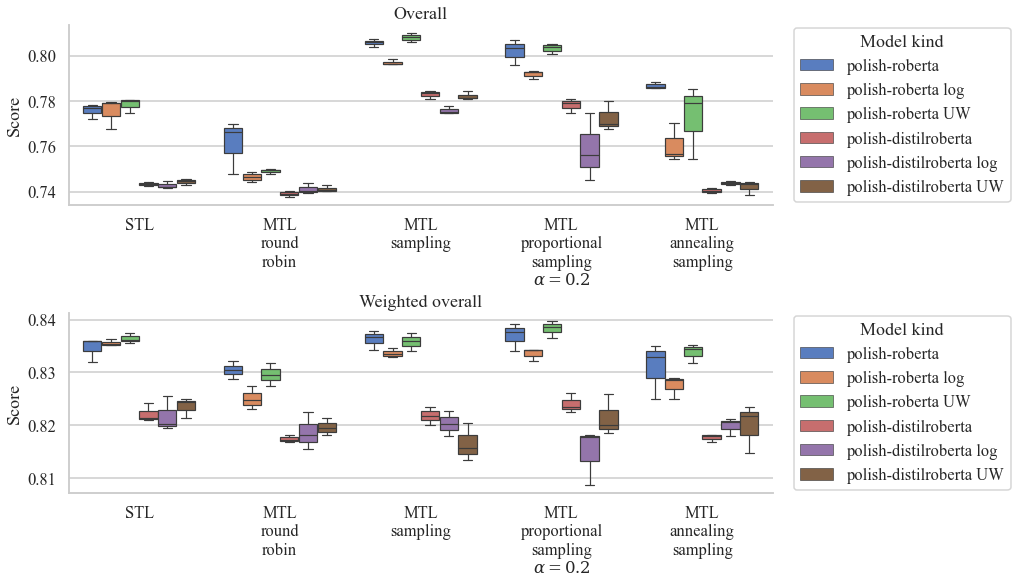

In [7]:
order = ['STL', 'MTL_round_robin', 'MTL_sampling', 
         'MTL_proportional_sampling_$\\alpha=0.2$', 'MTL_annealing_sampling']

hue_order = ['polish-roberta',  'polish-roberta log', 'polish-roberta UW', 'polish-distilroberta', 'polish-distilroberta log',
            'polish-distilroberta UW']

visualize_boxplot(
    df, tasks=tasks,
    cols=1, row_height=4, all_tasks=False,
    savefig=True, filename='mtl_polish_roberta_vs_distilroberta_results_plot',
    showfliers=True, linewidth=1.2, order=order, 
    hue='model_kind', hue_order=hue_order,
    ncol=1, loc='center right', bbox_to_anchor=(1.35, 0.5), only_fig_legend=False,
    runtimes=False, steps=False, 
)

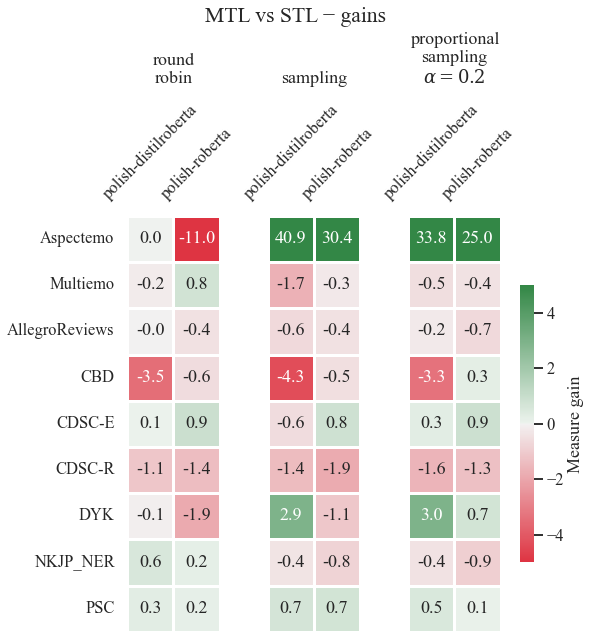

In [11]:
mtl_types = ['MTL_round_robin', 'MTL_sampling', 'MTL_proportional_sampling_$\\alpha=0.2$']
# mtl_types = ['MTL_proportional_sampling_$\\alpha=0.2$']

plot_gain_matrix(df, mtl_types=mtl_types, tasks=tasks, v_bound=5,
                 savefig=True, filename='mtl_polish_roberta_vs_distilroberta_gains')

# Eksperymenty 2

- Modyfikacje fun. straty: brak | _uncertainty weighting_
- Rodzaje MTL: round robin, sampling, proportional sampling $\alpha=0.2$, annealing sampling 
- Powtórzenia: 3
- Liczba Epok: 10
- Early stopping, patience=3
- Learning rate: 1e-5
- Max length: 256
- Batch size: 32

In [12]:
df = load_results_df('mtl_polish_roberta_vs_distilplrob_results_analysis2.csv')
df['model_kind'] = df.apply(lambda r: get_model_kind(r), axis=1)

In [37]:
# df[['batch_size', 'learning_rate', 'max_length', 'model_name', 'model_type', 'mt_dataset_type', 
#     'num_epochs', 'scale_class_loss', 'warmup_proportion', 'weight_decay', 'alpha', 'steps']].drop_duplicates()

In [57]:
# df['model_kind'].value_counts()
# df['type'].unique()

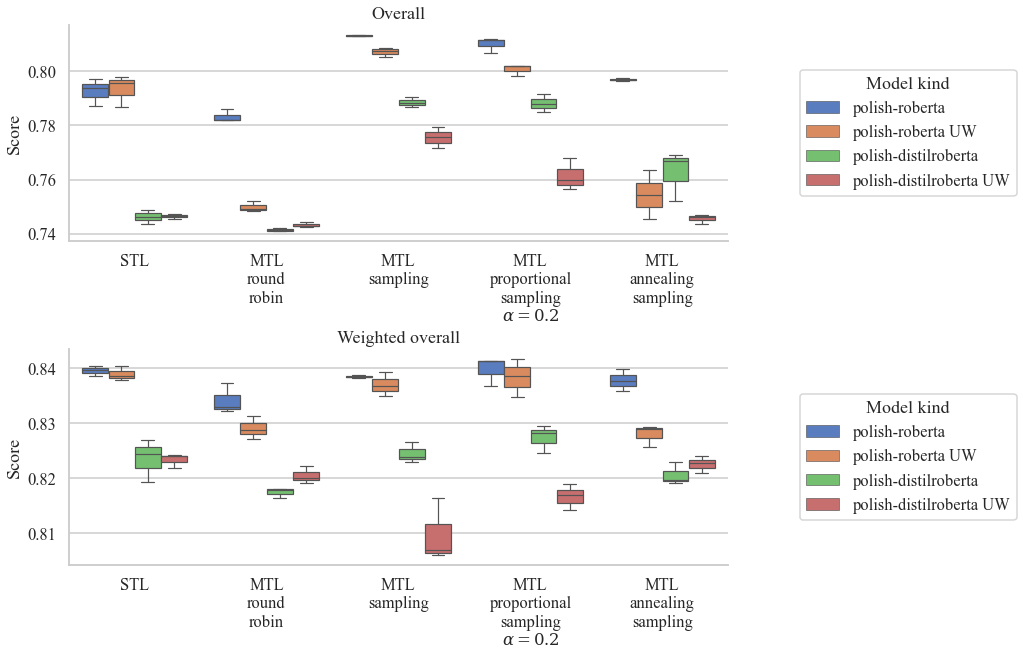

In [14]:
order = ['STL', 'MTL_round_robin', 'MTL_sampling', 
         'MTL_proportional_sampling_$\\alpha=0.2$', 'MTL_annealing_sampling']
hue_order = ['polish-roberta', 'polish-roberta UW', 'polish-distilroberta', 'polish-distilroberta UW']

visualize_boxplot(
    df, tasks=tasks,
    cols=1, row_height=4.5, fig_width=14, all_tasks=False,
    savefig=True, filename='mtl_polish_roberta_vs_distilroberta_2_results_plot',
    showfliers=True, linewidth=1.2, order=order, 
    hue='model_kind', 
    hue_order=hue_order,
    ncol=1, loc='center right', bbox_to_anchor=(1.45, 0.5), only_fig_legend=False,
    runtimes=False, steps=False, 
)

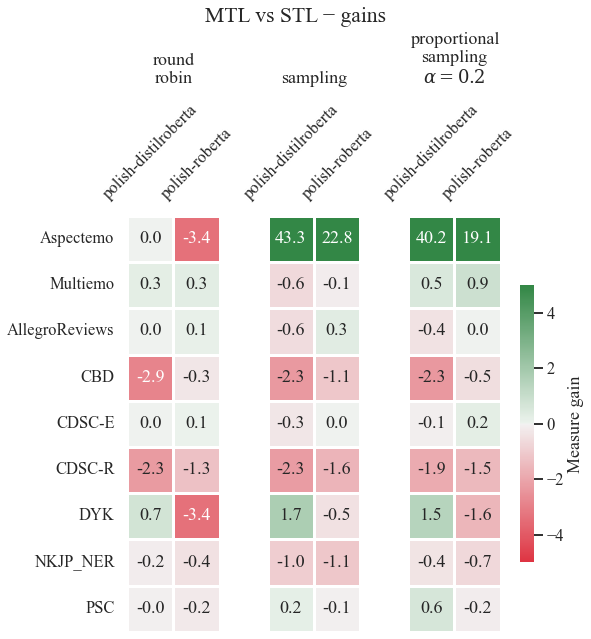

In [15]:
mtl_types = ['MTL_round_robin', 'MTL_sampling', 'MTL_proportional_sampling_$\\alpha=0.2$']
# mtl_types = ['MTL_proportional_sampling_$\alpha=0.2$']

plot_gain_matrix(df, mtl_types=mtl_types, tasks=tasks, v_bound=5,
                 savefig=True, filename='mtl_polish_roberta_vs_distilroberta_2_gains')